Next steps:
1. Add a "master node" that connects all nodes together, so that message passing works between all nodes

In [1]:
import pandas as pd

from EmbedDataset import LigandBinaryDataset

import time
import numpy as np
import torch
from torch_geometric.loader import DataLoader

In [2]:
dataset = LigandBinaryDataset('./data2/')

In [3]:
dataset = dataset.shuffle()
train_dataset = dataset[:int(len(dataset) * 0.7)]
val_dataset = dataset[int(len(dataset) * 0.7):int(len(dataset) * 0.85)]
test_dataset = dataset[int(len(dataset) * 0.85):]

In [4]:
train_dl = DataLoader(train_dataset, batch_size=16)
val_dl = DataLoader(val_dataset, batch_size=16)
test_dl = DataLoader(test_dataset, batch_size=16)

In [30]:
from LigandGNNV2 import LigandGNNV2
from LigandGNNV1 import LigandGNNV1
from sagn.models import SAGN

device = torch.device('cuda')
# model = LigandGNNV1(dataset.num_node_features, 1).to(device)
model = LigandGNNV2(100, 40).to(device)
# model = SAGN(in_feats=1070, hidden=1024, out_feats=1, num_hops=5, n_layers=2, num_heads=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([22]).to(device))

In [31]:
def train(model, loader, criterion, optimizer):
    model.train()

    loss_acc = 0.
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y

        loss = criterion(output, label.reshape(-1, 1))
        loss.backward()
        loss_acc += data.num_graphs * loss.item()
        optimizer.step()

    return loss_acc / len(loader.dataset)

In [32]:
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, auc, precision_recall_fscore_support, roc_auc_score

def evaluate(model, loader):
    model.eval()

    preds = np.asarray([])
    labels = np.asarray([])

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = torch.sigmoid(model(data).round().squeeze().cpu()).round().numpy()
            label = data.y.cpu().numpy()

            preds = np.concatenate([preds, pred])
            labels = np.concatenate([labels, label])

    precision, recall, _ = precision_recall_curve(labels, preds)
    fpr, tpr, thresholds = roc_curve(labels, preds, pos_label=1)
    print(precision_recall_fscore_support(labels, preds))
    return auc(fpr, tpr), auc(recall, precision)
    return roc_auc_score(labels, preds)

In [33]:
train_hist = []
val_hist = []

for epoch in range(1, 201):
    s = time.time()
    loss = train(model, train_dl, criterion, optimizer)
    train_score = evaluate(model, train_dl)
    val_score = evaluate(model, val_dl)
    scheduler.step(loss)
    e = time.time()

    train_hist.append(train_score)
    val_hist.append(val_score)

    if sum(val_score) > (.77 + .44) and sum(val_score) >= np.asarray(val_hist).sum(axis=1).max():
        print("saving...")
        torch.save(model.state_dict(), './models/BestModel.pt')

    # print(f'Epoch: {epoch:03d}, Loss: {loss:.05f}, Train Score: {train_score:.05f}, Val Score: {val_score:.05f}, Time: {e - s:.05f}s')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.05f}, Train Score: {train_score}, Val Score: {val_score}, Time: {e - s:.05f}s')

(array([0.98425352, 0.09431152]), array([0.77732695, 0.65090461]), array([0.86863677, 0.16475168]), array([341348,  12160], dtype=int64))
(array([0.98663361, 0.09202489]), array([0.74842895, 0.71547933]), array([0.85117987, 0.16307507]), array([63811,  2274], dtype=int64))
Epoch: 001, Loss: 1.06321, Train Score: (0.7141157780291205, 0.3786121700083981), Val Score: (0.7319541429149272, 0.4086473199395483), Time: 12.98501s
(array([0.9844847 , 0.14681642]), array([0.87293026, 0.61381579]), array([0.92535756, 0.23695614]), array([341348,  12160], dtype=int64))
(array([0.98707405, 0.15279283]), array([0.865227  , 0.68205805]), array([0.92214289, 0.24965795]), array([63811,  2274], dtype=int64))
Epoch: 002, Loss: 0.93647, Train Score: (0.743373027094436, 0.3869581045844286), Val Score: (0.7736425229866448, 0.42289566563009673), Time: 12.42100s
(array([0.98791682, 0.13100766]), array([0.83113421, 0.71463816]), array([0.90276903, 0.22142384]), array([341348,  12160], dtype=int64))
(array([0.98

KeyboardInterrupt: 

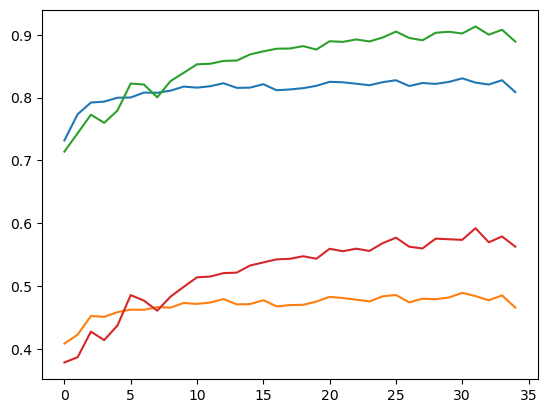

In [34]:
import matplotlib.pyplot as plt
plt.plot(val_hist)
plt.plot(train_hist)
plt.show()

In [35]:
evaluate(model, test_dl)

(array([0.98570121, 0.20968479]), array([0.90742846, 0.65106383]), array([0.94494672, 0.31720802]), array([74753,  2820], dtype=int64))


(0.7792461470983446, 0.4367167216336949)

In [36]:
model.load_state_dict(torch.load('./models/BestModel.pt'))
evaluate(model, test_dl)

(array([0.98623316, 0.18737614]), array([0.89029203, 0.67056738]), array([0.93581   , 0.29290582]), array([74753,  2820], dtype=int64))


(0.78042970215005, 0.43495966586540974)

In [13]:
data = test_dl.dataset[4].to(device)

In [14]:
pred = model(data)

In [15]:
out = torch.sigmoid(pred).round()
out

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [16]:
print(out.sum())
print(len(out))

tensor(65., device='cuda:0', grad_fn=<SumBackward0>)
403


In [17]:
len(data.y) / data.y.sum()

tensor(17.5217, device='cuda:0')

In [18]:
data.y.sum()

tensor(23., device='cuda:0')

In [19]:
f1_score(data.y.detach().cpu().numpy(), out.detach().cpu().numpy())

0.38636363636363635

In [ ]:
torch.save(model.state_dict(), './models/modelBest.pt')